# Respiratory infant mortality rate in Mexico by month of birth

Daniel E. Noyola, Héctor A. Milán, Juan C. Cuevas-Tello

Universidad Autónoma de San Luis Potosí

In [258]:
%pip install pandas matplotlib seaborn numpy statsmodels

Note: you may need to restart the kernel to use updated packages.


In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from itertools import product

**Change this variable to disable Gray Scale plotting**

```
grayscale = False
```

In [260]:

grayscale = True

In [261]:
# Helper variables
datasets_folder = 'Datasets'
plots_folder = 'Plots'
image_format = 'eps'

In [262]:
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Define a custom order for sorting, starting from July
custom_order = ['July', 'August', 'September', 'October', 'November', 'December',
                'January', 'February', 'March', 'April', 'May', 'June']

# Define a custom order for sorting, starting from April
occurence_custom_order = ['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December',
                'January', 'February', 'March']

## Registered Deaths
The following dataset contains statistics on registered deaths from the [Subsystem of Demographic and Social Information](https://en.www.inegi.org.mx/programas/edr/#open_data). 

It focuses exclusively on deaths of children under the age of one, occurring between April 2014 and March 2021. However, children born after March 30, 2020, are excluded from this analysis.

In [263]:
mortality_records_csv = f'{datasets_folder}/mortality_records.csv'

mortality_records_df = pd.read_csv(mortality_records_csv)
mortality_records_df = mortality_records_df.sort_values(by=['PERIODO_DEF', 'PERIODO_NAC'])

Total infants who died before their first birthday (from the children born between April 2014 and March 2020).

In [264]:

mortality_df = mortality_records_df[(mortality_records_df['ANIO_NACIM'] >= 2014) & (mortality_records_df['ANIO_NACIM'] <= 2020)]
mortality_df = mortality_df[((mortality_df['ANIO_NACIM'] == 2014) & (mortality_df['MES_NACIM'] > 3)) | (mortality_df['ANIO_NACIM'] > 2014)]
mortality_df = mortality_df[((mortality_df['ANIO_NACIM'] == 2020) & (mortality_df['MES_NACIM'] < 4)) | (mortality_df['ANIO_NACIM'] < 2020)]

print(f'Total deaths:  {len(mortality_df):,}')

Total deaths:  144,243


### Dataset Overview

This dataset contains 144,243 records, with each entry including the following features:

- **ENT_RESID**: State of residence (Identifier).
- **PERIODO_DEF**: Date of death, recorded in Year/Month format.
- **ANIO_OCUR**: Year of death.
- **MES_OCUR**: Month of death.
- **PERIODO_NAC**: Date of birth, recorded in Year/Month format.
- **ANIO_NACIM**: Year of birth.
- **MES_NACIM**: Month of birth.
- **CAUSA_DEF**: Cause of death, represented by the ICD-10 code.
- **EDAD**: Registered age at the time of death.

In [265]:
mortality_df.tail()

,ENT_RESID,PERIODO_DEF,ANIO_OCUR,MES_OCURR,PERIODO_NAC,ANIO_NACIM,MES_NACIM,CAUSA_DEF,EDAD
146862,12,2021/03,2021,3,2020/03,2020,3,B199,3011
146863,21,2021/03,2021,3,2020/03,2020,3,J988,3011
146870,26,2021/03,2021,3,2020/03,2020,3,Q243,3011
146872,23,2021/03,2021,3,2020/03,2020,3,J189,3011
146877,30,2021/03,2021,3,2020/03,2020,3,Q210,3011


Of the total recorded deaths, 8,805 were attributed to respiratory illnesses, classified under ICD-10 codes **J** and **U**.

In [266]:
respiratory_illness_df1 = mortality_df[(mortality_df['CAUSA_DEF'].str.startswith('J')) | (mortality_df['CAUSA_DEF'].str.startswith('U'))]


In [267]:
print(f'Deaths attributed to respiratory illnesses: {len(respiratory_illness_df1):,}')

Deaths attributed to respiratory illnesses: 8,805


## Registered Births

The following dataset contains statistics on registered births from the [Subsystem of Demographic and Social Information](https://www.inegi.org.mx/programas/natalidad/#datos_abiertos). 

It focuses exclusively on bitrhs occurring between April 2014 and March 2020.

In [268]:
birth_records_csv = f'{datasets_folder}/birth_records.csv'

birth_records_df = pd.read_csv(birth_records_csv)

Total births between April 2014 and March 2020 in Mexico

In [269]:
print(f'Total births: {len(birth_records_df):,}')

Total births: 12,604,902


### Dataset overview

This dataset contains 12,604,902 records, with each entry including the following features:

- **ENT_RESID**: State of residence (Identifier).
- **PERIODO_NAC**: Date of birth, recorded in Year/Month format.
- **ANO_NAC**: Year of birth.
- **MES_NAC**: Month of birth.

In [270]:
birth_records_df.head()

,ENT_RESID,PERIODO_NAC,ANO_NAC,MES_NAC,SEXO,EDAD_MADN,EDAD_PADN,ORDEN_PART,TIPO_NAC,LUGAR_PART,EDOCIV_MAD,ESCOL_MAD,ESCOL_PAD
0,1,2014/04,2014,4,2,32,36,1,1,2,2,7,7
1,1,2014/04,2014,4,2,26,25,1,1,4,2,5,6
2,1,2014/04,2014,4,2,29,29,2,1,2,2,7,7
3,1,2014/04,2014,4,1,28,29,1,1,2,2,7,6
4,1,2014/04,2014,4,1,30,26,1,1,2,3,7,5


## Statistics on registered deaths

Overall, there were 12,604,902 births between April 2014 and March 2020 in Mexico for which maternal residence was one of the 32 Mexican states. 
Of these infants, 144,244 died before their first birthday, corresponding to an infant mortality rate of 11.44 deaths/1,000 births; 8,805 deaths were caused by respiratory illness, corresponding to a respiratory-infant mortality rate of 0.7 deaths/per 1,000 births. As such, respiratory deaths accounted for 6.1% of all demises in infants during the first year of life. Most respiratory deaths (6,531/8,805; 74.1%) corresponded to acute respiratory infections, including COVID-19 (Table 1).

In [271]:
print(f'Infant Mortality Rate: {(len(mortality_df) /  len(birth_records_df) *  1000):.2f} deaths / 1,000 births')
print(f'Infant mortality Rate (Respiratory Ilness): {(len(respiratory_illness_df1) /  len(birth_records_df) *  1000):.2f} per 1,000 births')
print(f'Respiratory deaths (percentage): {(len(respiratory_illness_df1) /  len(mortality_df) *  100):.2f}%')

Infant Mortality Rate: 11.44 deaths / 1,000 births
Infant mortality Rate (Respiratory Ilness): 0.70 per 1,000 births
Respiratory deaths (percentage): 6.10%


In [272]:
# Ranges and corresponding diagnoses from the provided table
ranges = {
    "J00X-J069": "Upper respiratory tract infections",
    "J09X-J118": "Influenza",
    "J120-J129": "Viral pneumonia",
    "J13X-J159": "Bacterial pneumonia",
    "J168-J189": "Pneumonia by other agents and non-specified",
    "J200-J219": "Bronchitis and bronchiolitis",
    "J22X": "Acute lower respiratory tract infection, non-specified",
    "J304-J348": "Rhinitis and other nasal disorders",
    "J380-J399": "Laryngeal, pharyngeal and other upper respiratory tract disorders",
    "J42X-J449": "Bronchitis, emphysema, and other chronic lung diseases",
    "J450-J46X": "Asthma",
    "J677-J849": "Pneumonitis associated to diverse conditions and other lung disorders",
    "J852-J948": "Pulmonary abscess, pneumothorax and other pleural space disorders",
    "J960-J969": "Acute and chronic respiratory failure",
    "J980-J989": "Diverse tracheal, bronchial, and lung disorders",
    "U071-U072": "COVID-19"
}

# Function to extract the numeric part of ICD-10 code
def extract_numeric_part(code):
    return ''.join(filter(str.isdigit, code))

# Function to categorize the ICD-10 codes based on ranges or single values
def categorize_code(code):
    for range_key in ranges:
        if '-' in range_key:  # This is a range of codes
            start_range, end_range = range_key.split('-')
            start_numeric = extract_numeric_part(start_range)
            end_numeric = extract_numeric_part(end_range)
            code_numeric = extract_numeric_part(code)

            # Check if the numeric part of the code falls within the range
            if start_range[:1] == code[:1] and start_numeric <= code_numeric <= end_numeric:
                return range_key
        else:  # This is a single ICD-10 code (e.g., J22X)
            if code.startswith(range_key[:3]):  # Match the first part of the code (e.g., J22)
                return range_key
    return None

grouped_df = respiratory_illness_df1.groupby('CAUSA_DEF').size().reset_index(name='Deaths')

# Add a column to categorize the ICD-10 codes
grouped_df['Category'] = grouped_df['CAUSA_DEF'].apply(categorize_code)

# Group by the ICD-10 categories and sum the deaths
grouped_df = grouped_df.groupby('Category')['Deaths'].sum().reset_index()

# Merge the grouped data with the corresponding diagnoses
grouped_df['Diagnoses'] = grouped_df['Category'].map(ranges)

# Calculate the percentage of total deaths (8805 deaths)
total_deaths = grouped_df['Deaths'].sum()
grouped_df['Percentage'] = (grouped_df['Deaths'] / total_deaths * 100).apply(lambda x: round(x, 2))

# Rearrange columns for the final table format
grouped_df = grouped_df[['Category', 'Diagnoses', 'Deaths', 'Percentage']].sort_values(by='Category')


**Table  1.** Respiratory mortality diagnoses for Mexican infants born between April 2014 and March 2020 who died during the first year

In [273]:
grouped_df.head(16)

,Category,Diagnoses,Deaths,Percentage
0,J00X-J069,Upper respiratory tract infections,199,2.26
1,J09X-J118,Influenza,93,1.06
2,J120-J129,Viral pneumonia,54,0.61
3,J13X-J159,Bacterial pneumonia,282,3.20
4,J168-J189,Pneumonia by other agents and non-specified,4932,56.01
5,J200-J219,Bronchitis and bronchiolitis,545,6.19
6,J22X,"Acute lower respiratory tract infection, non-s...",338,3.84
7,J304-J348,Rhinitis and other nasal disorders,8,0.09
8,J380-J399,"Laryngeal, pharyngeal and other upper respirat...",30,0.34
9,J42X-J449,"Bronchitis, emphysema, and other chronic lung ...",74,0.84


**Figure 1.** Monthly respiratory infant mortality rate in Mexico according to date of demise and birthdate between April 2014 and March 2020

The following code creates a dataset containig mortality rates based on both month of occurence and month of birth


In [274]:
# Registered deaths grouped by year/month of birth 
grouped_deaths_df1 = respiratory_illness_df1.groupby('PERIODO_NAC').size().reset_index(name='Deaths_Birth')
# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby('PERIODO_NAC').size().reset_index(name='Births')

# Registered respiratory illness deaths grouped by year/month of occurence 
respiratory_illness_df2 = mortality_records_df[(mortality_records_df['CAUSA_DEF'].str.startswith('J')) | (mortality_records_df['CAUSA_DEF'].str.startswith('U'))]
grouped_deaths_df2 = respiratory_illness_df2.groupby('PERIODO_DEF').size().reset_index(name='Deaths_Occurence')

grouped_df = pd.merge(grouped_births_df, grouped_deaths_df1, on='PERIODO_NAC', how='inner')
grouped_df = pd.merge(grouped_df, grouped_deaths_df2, left_on='PERIODO_NAC', right_on='PERIODO_DEF', how='inner')

grouped_df.drop(columns=['PERIODO_DEF'], inplace=True)
grouped_df['Mortality_Rate_Birth'] =  grouped_df['Deaths_Birth'] / grouped_df['Births'] *  1000
grouped_df['Mortality_Rate_Occurence'] =  grouped_df['Deaths_Occurence'] / grouped_df['Births'] *  1000

grouped_df.head()

,PERIODO_NAC,Births,Deaths_Birth,Deaths_Occurence,Mortality_Rate_Birth,Mortality_Rate_Occurence
0,2014/04,176479,102,97,0.577972,0.549640
1,2014/05,182031,142,110,0.780087,0.604293
2,2014/06,178619,132,95,0.739003,0.531858
3,2014/07,191022,159,117,0.832365,0.612495
4,2014/08,200111,165,85,0.824542,0.424764


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


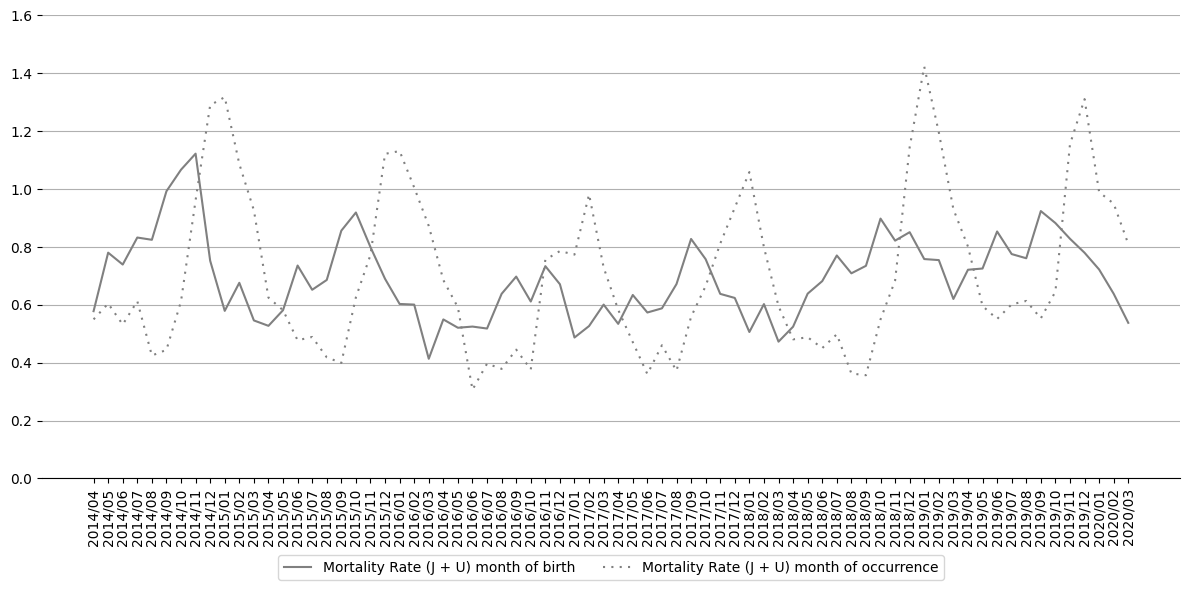

In [275]:

# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting Mortality Rate based on Birth
plt.plot(grouped_df['PERIODO_NAC'], grouped_df['Mortality_Rate_Birth'], label='Mortality Rate (J + U) month of birth',  linestyle='-', color='gray' if grayscale else 'orange')

# Plotting Mortality Rate based on Occurrence
plt.plot(grouped_df['PERIODO_NAC'], grouped_df['Mortality_Rate_Occurence'], label='Mortality Rate (J + U) month of occurrence',  linestyle=(0, (1, 3)), color='gray' if grayscale else 'blue')


plt.legend()

plt.xticks(rotation=90, ha='center')

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])  # You can specify any list of values for the y-ticks


# Show grid
plt.grid(axis='y')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2) 

# Remove grid borders (spines)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  

# Adjust layout
plt.tight_layout()

plt.savefig(f'{plots_folder}/Fig1.{image_format}', format=image_format, dpi=1200)


# Display the plot
plt.show()

**Figure 2.** Average monthly respiratory (J and U ICD-10 codes) infant mortality rates based on month of occurrence and month of birth in Mexico (April 2014-March 2020).

In [276]:
def rate_and_ci(deaths, births, scale=1000.0, z=1.96):
    deaths = deaths.astype(float)
    births = births.astype(float)
    rate = np.round((deaths / births) * scale, 2)
    se = np.sqrt(deaths) / births * scale
    lo = np.round(np.maximum(0.0, rate - z * se), 2)
    hi = np.round(rate + z * se, 2)
    return rate, lo, hi

In [277]:
# Registered deaths grouped by year/month of birth 
grouped_deaths_df1 = respiratory_illness_df1.groupby('MES_NACIM').size().reset_index(name='Deaths_Birth')
# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby('MES_NAC').size().reset_index(name='Births')

# Registered respiratory illness deaths grouped by year/month of occurence 
respiratory_illness_df2 = mortality_records_df[(mortality_records_df['CAUSA_DEF'].str.startswith('J')) | (mortality_records_df['CAUSA_DEF'].str.startswith('U'))]
grouped_deaths_df2 = respiratory_illness_df2.groupby('MES_OCURR').size().reset_index(name='Deaths_Occurence')

grouped_df = pd.merge(grouped_births_df, grouped_deaths_df1, left_on='MES_NAC', right_on='MES_NACIM', how='inner')
grouped_df = pd.merge(grouped_df, grouped_deaths_df2, left_on='MES_NAC', right_on='MES_OCURR', how='inner')

grouped_df.drop(columns=['MES_NACIM', 'MES_OCURR'], inplace=True)

rate, lo, hi = rate_and_ci(grouped_df['Deaths_Birth'], grouped_df['Births'])
grouped_df['Mortality_Rate_Birth'] =  rate
grouped_df['Mortality_Rate_Birth_Lower'] =  lo
grouped_df['Mortality_Rate_Birth_Upper'] =  hi

rate, lo, hi = rate_and_ci(grouped_df['Deaths_Occurence'], grouped_df['Births'])
grouped_df['Mortality_Rate_Occurence'] =  rate
grouped_df['Mortality_Rate_Occurence_Lower'] =  lo
grouped_df['Mortality_Rate_Occurence_Upper'] =  hi

# Replace the 'MES_NAC' values with month names
grouped_df['MES_NAC'] = grouped_df['MES_NAC'].map(month_mapping)

# Convert the 'MES_NAC' column to a categorical type with the custom order
grouped_df['MES_NAC'] = pd.Categorical(grouped_df['MES_NAC'], categories=custom_order, ordered=True)

# Sort the dataframe based on the custom order
grouped_df = grouped_df.sort_values('MES_NAC')

grouped_df.head(12)

,MES_NAC,Births,Deaths_Birth,Deaths_Occurence,Mortality_Rate_Birth,Mortality_Rate_Birth_Lower,Mortality_Rate_Birth_Upper,Mortality_Rate_Occurence,Mortality_Rate_Occurence_Lower,Mortality_Rate_Occurence_Upper
6,July,1076970,741,624,0.69,0.64,0.74,0.58,0.53,0.63
7,August,1136385,812,517,0.71,0.66,0.76,0.45,0.41,0.49
8,September,1181923,992,567,0.84,0.79,0.89,0.48,0.44,0.52
9,October,1153400,989,688,0.86,0.81,0.91,0.60,0.56,0.64
10,November,1056550,874,917,0.83,0.78,0.88,0.87,0.81,0.93
11,December,1067736,774,1180,0.72,0.67,0.77,1.11,1.05,1.17
0,January,1019441,616,1145,0.60,0.55,0.65,1.12,1.05,1.19
1,February,902558,570,906,0.63,0.58,0.68,1.00,0.93,1.07
2,March,986549,523,803,0.53,0.48,0.58,0.81,0.75,0.87
3,April,994946,567,708,0.57,0.52,0.62,0.71,0.66,0.76


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


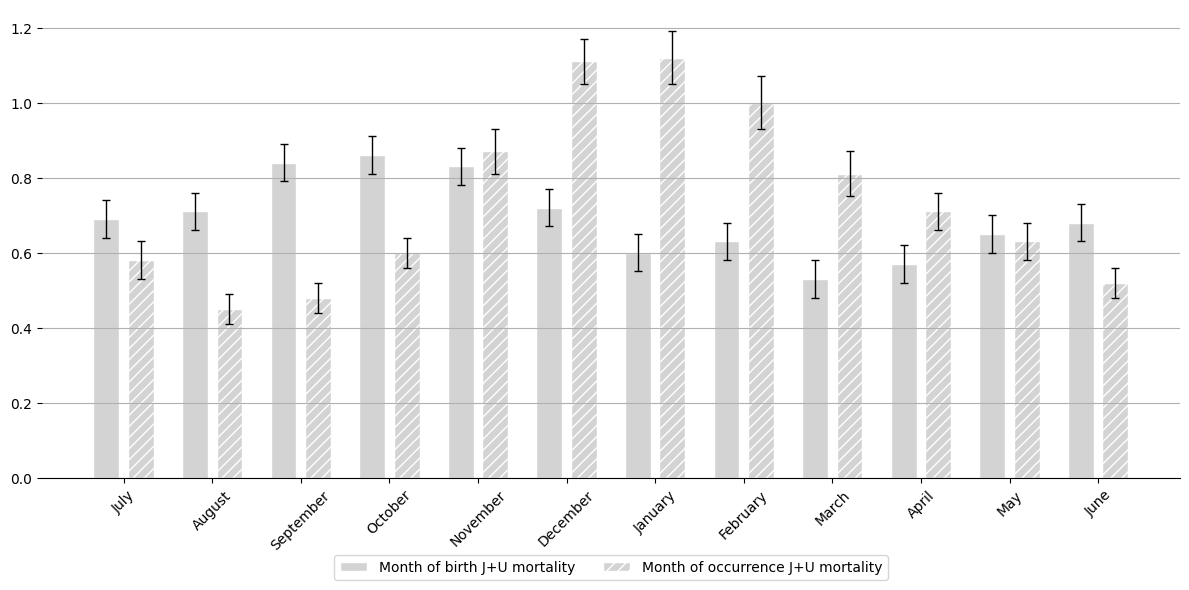

In [278]:

months = grouped_df['MES_NAC']
mortality_rate_birth = grouped_df['Mortality_Rate_Birth']
ci95_Lower_birth = grouped_df['Mortality_Rate_Birth_Lower']
ci95_Upper_birth = grouped_df['Mortality_Rate_Birth_Upper']
mortality_rate_occurrence = grouped_df['Mortality_Rate_Occurence']
ci95_Lower_occurrence = grouped_df['Mortality_Rate_Occurence_Lower']
ci95_Upper_occurrence = grouped_df['Mortality_Rate_Occurence_Upper']

# Set up the figure and axis
plt.figure(figsize=(12, 6))

# Set bar width
bar_width = 0.35

# Set positions for each bar
index = np.arange(len(months)) *  1.2

# Create bars for Month of Birth Mortality Rate
plt.bar(index - bar_width / 3, 
        mortality_rate_birth, 
        bar_width, 
        label='Month of birth J+U mortality', 
        color='lightgray' if grayscale else 'orange', 
        edgecolor='white')

# Error bars
plt.errorbar(index - bar_width / 3, 
        mortality_rate_birth,
        yerr=[mortality_rate_birth-ci95_Lower_birth,
                ci95_Upper_birth-mortality_rate_birth],
        color='black', 
        fmt='none', 
        elinewidth=1, 
        capsize=3)

# Create bars for Month of Occurrence Mortality Rate, offset by bar_width
plt.bar(index + bar_width, 
        mortality_rate_occurrence, 
        bar_width, label='Month of occurrence J+U mortality', 
        hatch='///', 
        color='lightgray' if grayscale else 'blue', 
        edgecolor='white')

# Error bars
plt.errorbar(index + bar_width, 
        mortality_rate_occurrence,
        yerr=[mortality_rate_occurrence-ci95_Lower_occurrence,
                ci95_Upper_occurrence-mortality_rate_occurrence],
        color='black', 
        fmt='none', 
        elinewidth=1, 
        capsize=3)


plt.legend()

plt.xticks(index + bar_width / 3, months, rotation=45, ha='center')

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])  # You can specify any list of values for the y-ticks


# Show grid
plt.grid(axis='y')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2) 

# Remove grid borders (spines)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  

# Adjust layout
plt.tight_layout()

plt.savefig(f'{plots_folder}/Fig2.{image_format}', format=image_format, dpi=1200)


# Display the plot
plt.show()

### Chi-square test of homogeneity to evaluate overall seasonal variation

1. Mortality rates based on the month of occurrence
2. Mortality rates based on the month of birth

In [279]:
from scipy.stats import chi2_contingency

# Example for months
table = np.array([grouped_df['Deaths_Occurence'], grouped_df['Births'] - grouped_df['Deaths_Occurence']])
chi2, p, dof, expected = chi2_contingency(table)


print(f"Chi² = {chi2:.3f}, df = {dof}, p-value = {p:.3e}")

Chi² = 907.086, df = 11, p-value = 1.858e-187


In [280]:
from scipy.stats import chi2_contingency

# Example for months
table = np.array([grouped_df['Deaths_Birth'], grouped_df['Births'] - grouped_df['Deaths_Birth']])
chi2, p, dof, expected = chi2_contingency(table)


print(f"Chi² = {chi2:.3f}, df = {dof}, p-value = {p:.3e}")

Chi² = 188.850, df = 11, p-value = 1.520e-34


### Respiratory Mortality Rates by State and Region

To precisely calculate respiratory mortality rates, we first need to retrieve the list of Mexican states along with their corresponding regions. The dataset **State.csv** provides the complete list of Mexican states as of 2024, categorized by their respective regions. This data will serve as the foundation for calculating and analyzing the respiratory mortality rates across different geographic areas.

In [281]:
states_df = pd.read_csv(f'{datasets_folder}/State.csv')

#Let's print the first records.
states_df.head(20)

,ENTIDAD,NOM_ENTIDAD,REGION
0,1,Aguascalientes,Centro Occidente
1,2,Baja California,Noroeste
2,3,Baja California Sur,Noroeste
3,4,Campeche,Yucatan
4,5,Coahuila de Zaragoza,Norte
5,6,Colima,Centro Occidente
6,7,Chiapas,Sur
7,8,Chihuahua,Norte
8,9,Ciudad de Mexico,Centro Este
9,10,Durango,Norte


In [282]:
grouped_deaths = respiratory_illness_df1.groupby('ENT_RESID').size().reset_index(name='Deaths')
grouped_deaths.head()

,ENT_RESID,Deaths
0,1,80
1,2,209
2,3,36
3,4,58
4,5,169


In [283]:
grouped_births = birth_records_df.groupby('ENT_RESID').size().reset_index(name='Births')
grouped_births.head()

,ENT_RESID,Births
0,1,154704
1,2,318748
2,3,71916
3,4,94852
4,5,335568


**Supplementary Table 1.** Respiratory infant mortality rate by state.

In [284]:
grouped_df = pd.merge(states_df, grouped_births, left_on='ENTIDAD', right_on='ENT_RESID', how='inner')
grouped_df = pd.merge(grouped_df, grouped_deaths, left_on='ENTIDAD', right_on='ENT_RESID', how='inner')
# Drop unused columns and rename existing ones
grouped_df.drop(columns=['ENT_RESID_x', 'ENT_RESID_y'], inplace=True)
grouped_df.rename(columns={'ENTIDAD': 'State_Code', 'NOM_ENTIDAD': 'State'}, inplace=True)

# Calculate and append the totals
totals = grouped_df[['Births', 'Deaths']].sum()
totals_row = pd.DataFrame([totals], columns=grouped_df.columns)
totals_row['State'] = 'Mexico (Country)'
totals_row['REGION'] = 'TOTAL'
grouped_df = pd.concat([grouped_df, totals_row], ignore_index=True)

r, lo, hi = rate_and_ci(grouped_df['Deaths'].values, grouped_df['Births'].values)

grouped_df['Respiratory_Mortality_Rate'] = r
grouped_df['CI95_Lower'] = lo
grouped_df['CI95_Upper'] = hi
grouped_df.head(33)

,State_Code,State,REGION,Births,Deaths,Respiratory_Mortality_Rate,CI95_Lower,CI95_Upper
0,1.0,Aguascalientes,Centro Occidente,154704.0,80.0,0.52,0.41,0.63
1,2.0,Baja California,Noroeste,318748.0,209.0,0.66,0.57,0.75
2,3.0,Baja California Sur,Noroeste,71916.0,36.0,0.50,0.34,0.66
3,4.0,Campeche,Yucatan,94852.0,58.0,0.61,0.45,0.77
4,5.0,Coahuila de Zaragoza,Norte,335568.0,169.0,0.50,0.42,0.58
5,6.0,Colima,Centro Occidente,66398.0,27.0,0.41,0.26,0.56
6,7.0,Chiapas,Sur,780847.0,1093.0,1.40,1.32,1.48
7,8.0,Chihuahua,Norte,353264.0,314.0,0.89,0.79,0.99
8,9.0,Ciudad de Mexico,Centro Este,682342.0,497.0,0.73,0.67,0.79
9,10.0,Durango,Norte,204847.0,165.0,0.81,0.69,0.93


**Supplementary Table 2.** States included in each of the eight regions analyzed in the study.

In [285]:
pd.set_option('display.max_colwidth', 150)
grouped_df = states_df.groupby('REGION')['NOM_ENTIDAD'].apply(lambda x: ', '.join(x)).reset_index()
grouped_df.columns = ['Region', 'States']
grouped_df.head(8)


,Region,States
0,Centro Este,"Ciudad de Mexico, Hidalgo, Mexico, Morelos, Puebla, Queretaro, Tlaxcala"
1,Centro Occidente,"Aguascalientes, Colima, Guanajuato, Jalisco, Michoacan de Ocampo"
2,Centro Sur,"Tabasco, Veracruz de Ignacio de la Llave"
3,Noreste,"Nuevo Leon, Tamaulipas"
4,Noroeste,"Baja California, Baja California Sur, Nayarit, Sinaloa, Sonora"
5,Norte,"Coahuila de Zaragoza, Chihuahua, Durango, San Luis Potosi, Zacatecas"
6,Sur,"Chiapas, Guerrero, Oaxaca"
7,Yucatan,"Campeche, Quintana Roo, Yucatan"


In [286]:
# Restore default settings after customization
pd.reset_option('display.max_colwidth')

#### Monthly Mortality Rates (National)

In [287]:
# Registered deaths grouped by year/month of birth 
grouped_deaths_df1 = respiratory_illness_df1.groupby('MES_NACIM').size().reset_index(name='Deaths_Birth')
# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby('MES_NAC').size().reset_index(name='Births')


grouped_df = pd.merge(grouped_births_df, grouped_deaths_df1, left_on='MES_NAC', right_on='MES_NACIM', how='inner')

grouped_df.drop(columns=['MES_NACIM'], inplace=True)
grouped_df['Mortality_Rate_Birth'] =  (grouped_df['Deaths_Birth'] / grouped_df['Births'] *  1000).apply(lambda x: round(x, 2))

# Replace the 'MES_NAC' values with month names
grouped_df['MES_NAC'] = grouped_df['MES_NAC'].map(month_mapping)

# Convert the 'MES_NAC' column to a categorical type with the custom order
grouped_df['MES_NAC'] = pd.Categorical(grouped_df['MES_NAC'], categories=custom_order, ordered=True)

# Sort the dataframe based on the custom order
grouped_df = grouped_df.sort_values('MES_NAC')

grouped_df.rename(columns={'MES_NAC': 'Month', 'Mortality_Rate_Birth': 'Mortality_Rate'}, inplace=True)
monthly_mortality_rates = grouped_df[['Month', 'Mortality_Rate']]
monthly_mortality_rates.head(12)


,Month,Mortality_Rate
6,July,0.69
7,August,0.71
8,September,0.84
9,October,0.86
10,November,0.83
11,December,0.72
0,January,0.60
1,February,0.63
2,March,0.53
3,April,0.57


In [288]:
def fit_count_glm(formula, data, offset_col, family='poisson'):
    if family == 'poisson':
        fam = sm.families.Poisson()
    else:
        fam = sm.families.NegativeBinomial()
        
    model = smf.glm(formula=formula,
                    data=data,
                    family=fam,
                    offset=np.log(data[offset_col])).fit()
    return model

def dispersion_ratio(model):
    return model.pearson_chi2 / model.df_resid


#### Respiratory Mortality Rates (Grouped by Region)

In [289]:
# Registered deaths grouped by year/month of birth 
grouped_deaths_df = respiratory_illness_df1.groupby(['ENT_RESID','MES_NACIM']).size().reset_index(name='Deaths')
grouped_deaths_df = pd.merge(grouped_deaths_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')
#grouped_deaths_df = grouped_deaths_df.groupby(['REGION','MES_NACIM']).size().reset_index(name='Deaths')

# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby(['ENT_RESID','MES_NAC']).size().reset_index(name='Births')
grouped_births_df = pd.merge(grouped_births_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')
grouped_births_df.head()

grouped_df = pd.merge(grouped_births_df, grouped_deaths_df, left_on=['ENT_RESID', 'MES_NAC'], right_on=['ENT_RESID', 'MES_NACIM'], how='left')
grouped_df.drop(columns=['ENTIDAD_x','MES_NACIM','ENTIDAD_y','NOM_ENTIDAD_y', 'REGION_y'], inplace=True)
grouped_df.rename(columns={'REGION_x': 'Region', 'NOM_ENTIDAD_x': 'State', 'MES_NAC': 'Month'}, inplace=True)
grouped_df['Deaths'] = grouped_df['Deaths'].fillna(0)

regional_mortality_rates = grouped_df.groupby(['Region'])[['Births', 'Deaths']].sum().reset_index()
r, lo, hi = rate_and_ci(regional_mortality_rates['Deaths'].values, regional_mortality_rates['Births'].values)
regional_mortality_rates['Mortality_Rate'] =  r
regional_mortality_rates['CI95_Lower'] = lo
regional_mortality_rates['CI95_Upper'] = hi

regional_mortality_rates.drop(columns=['Births','Deaths'], inplace=True)

regional_mortality_rates.head(9)

,Region,Mortality_Rate,CI95_Lower,CI95_Upper
0,Centro Este,0.67,0.64,0.70
1,Centro Occidente,0.57,0.54,0.60
2,Centro Sur,0.79,0.73,0.85
3,Noreste,0.50,0.45,0.55
4,Noroeste,0.66,0.61,0.71
5,Norte,0.67,0.63,0.71
6,Sur,1.02,0.97,1.07
7,Yucatan,0.82,0.74,0.90


In [290]:
national_mortality_rate = grouped_df['Deaths'].sum() / grouped_df['Births'].sum() *  1000
print(f'Respiratory infant mortality rate: {national_mortality_rate:.2f}%')

Respiratory infant mortality rate: 0.70%


**Table 2.** Respiratory infant mortality rates by birth month in Mexican children born between April 2014 and March 2020.

In [291]:
# Registered deaths grouped by year/month of birth 
grouped_deaths_df = respiratory_illness_df1.groupby(['ENT_RESID','MES_NACIM']).size().reset_index(name='Deaths')
grouped_deaths_df = pd.merge(grouped_deaths_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')
#grouped_deaths_df = grouped_deaths_df.groupby(['REGION','MES_NACIM']).size().reset_index(name='Deaths')

# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby(['ENT_RESID','MES_NAC']).size().reset_index(name='Births')
grouped_births_df = pd.merge(grouped_births_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')

grouped_df = pd.merge(grouped_births_df, grouped_deaths_df, left_on=['ENT_RESID', 'MES_NAC'], right_on=['ENT_RESID', 'MES_NACIM'], how='left')
grouped_df.drop(columns=['ENTIDAD_x','MES_NACIM','ENTIDAD_y','NOM_ENTIDAD_y', 'REGION_y'], inplace=True)
grouped_df.rename(columns={'REGION_x': 'Region', 'NOM_ENTIDAD_x': 'State', 'MES_NAC': 'Month'}, inplace=True)
grouped_df['Deaths'] = grouped_df['Deaths'].fillna(0)

grouped_df = grouped_df.groupby(['Region', 'Month'])[['Births', 'Deaths']].sum().reset_index()
r, lo, hi = rate_and_ci(grouped_df['Deaths'].values, grouped_df['Births'].values)
grouped_df['Mortality_Rate'] =  r

# Calculate confidence intervals
ci_df = grouped_df.groupby(['Region', 'Month'])[['Births', 'Deaths']].sum().reset_index()
ci_df['Rate'], ci_df['CI_Lower'], ci_df['CI_Upper'] = rate_and_ci(ci_df['Deaths'], ci_df['Births'])

# merge with month names and order
ci_df['Month'] = ci_df['Month'].map(month_mapping)
ci_df['Month'] = pd.Categorical(ci_df['Month'], categories=custom_order, ordered=True)
ci_df = ci_df.sort_values(['Region', 'Month'])

pivot_df = grouped_df.pivot(index='Month', columns='Region', values='Mortality_Rate').reset_index()

# Replace the 'Month' values with month names
pivot_df['Month'] = pivot_df['Month'].map(month_mapping)

# Convert the 'Month' column to a categorical type with the custom order
pivot_df['Month'] = pd.Categorical(pivot_df['Month'], categories=custom_order, ordered=True)

# Sort the dataframe based on the custom order
pivot_df = pivot_df.sort_values('Month')

# Add national mortality rates
pivot_df['National'] = monthly_mortality_rates['Mortality_Rate']

# Add regional mortality rates
totals_row = pd.DataFrame({
    'Month': ['Yearly Avg'],
    'Centro Este': [regional_mortality_rates['Mortality_Rate'].iloc[0]],
    'Centro Occidente': [regional_mortality_rates['Mortality_Rate'].iloc[1]],
    'Centro Sur': [regional_mortality_rates['Mortality_Rate'].iloc[2]],
    'Noreste': [regional_mortality_rates['Mortality_Rate'].iloc[3]],
    'Noroeste': [regional_mortality_rates['Mortality_Rate'].iloc[4]],
    'Norte': [regional_mortality_rates['Mortality_Rate'].iloc[5]],
    'Sur': [regional_mortality_rates['Mortality_Rate'].iloc[6]],
    'Yucatan': [regional_mortality_rates['Mortality_Rate'].iloc[7]],
    'National': [national_mortality_rate]
})

pivot_df = pd.concat([pivot_df, totals_row], ignore_index=True)

# Rename columns (For visualization purposes only)
pivot_df.rename(columns={
    'Centro Este': 'East-central',
    'Centro Occidente': 'West-central',
    'Centro Sur': 'South-central',
    'Noreste': 'Northeast',
    'Noroeste': 'Northwest',
    'Norte': 'North',
    'Sur': 'South',
    'Yucatan': 'Yucatan peninsula',
    }, inplace=True)

# Rename ci_df Region values for consistency
ci_df['Region'] = ci_df['Region'].replace({
    'Centro Este': 'East-central',
    'Centro Occidente': 'West-central',
    'Centro Sur': 'South-central',
    'Noreste': 'Northeast',
    'Noroeste': 'Northwest',
    'Norte': 'North',
    'Sur': 'South',
    'Yucatan': 'Yucatan peninsula',
    })

pivot_df.loc[:, pivot_df.columns != 'Month'] = pivot_df.loc[:, pivot_df.columns != 'Month'].round(2)

pivot_df.head(13)

,Month,East-central,West-central,South-central,Northeast,Northwest,North,South,Yucatan peninsula,National
0,July,0.69,0.51,0.85,0.52,0.67,0.64,0.95,0.78,0.69
1,August,0.74,0.59,0.73,0.36,0.75,0.77,0.97,0.70,0.71
2,September,0.80,0.73,1.02,0.52,0.91,0.86,1.02,1.03,0.84
3,October,0.96,0.71,0.86,0.52,0.72,0.79,1.05,1.22,0.86
4,November,0.84,0.71,0.92,0.63,0.79,0.93,0.93,0.88,0.83
5,December,0.72,0.62,0.86,0.58,0.78,0.60,0.98,0.60,0.72
6,January,0.49,0.52,0.83,0.51,0.52,0.59,0.95,0.73,0.60
7,February,0.52,0.45,0.75,0.39,0.69,0.64,1.11,0.84,0.63
8,March,0.43,0.42,0.45,0.36,0.32,0.62,1.08,0.62,0.53
9,April,0.51,0.50,0.65,0.45,0.55,0.41,0.96,0.45,0.57


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


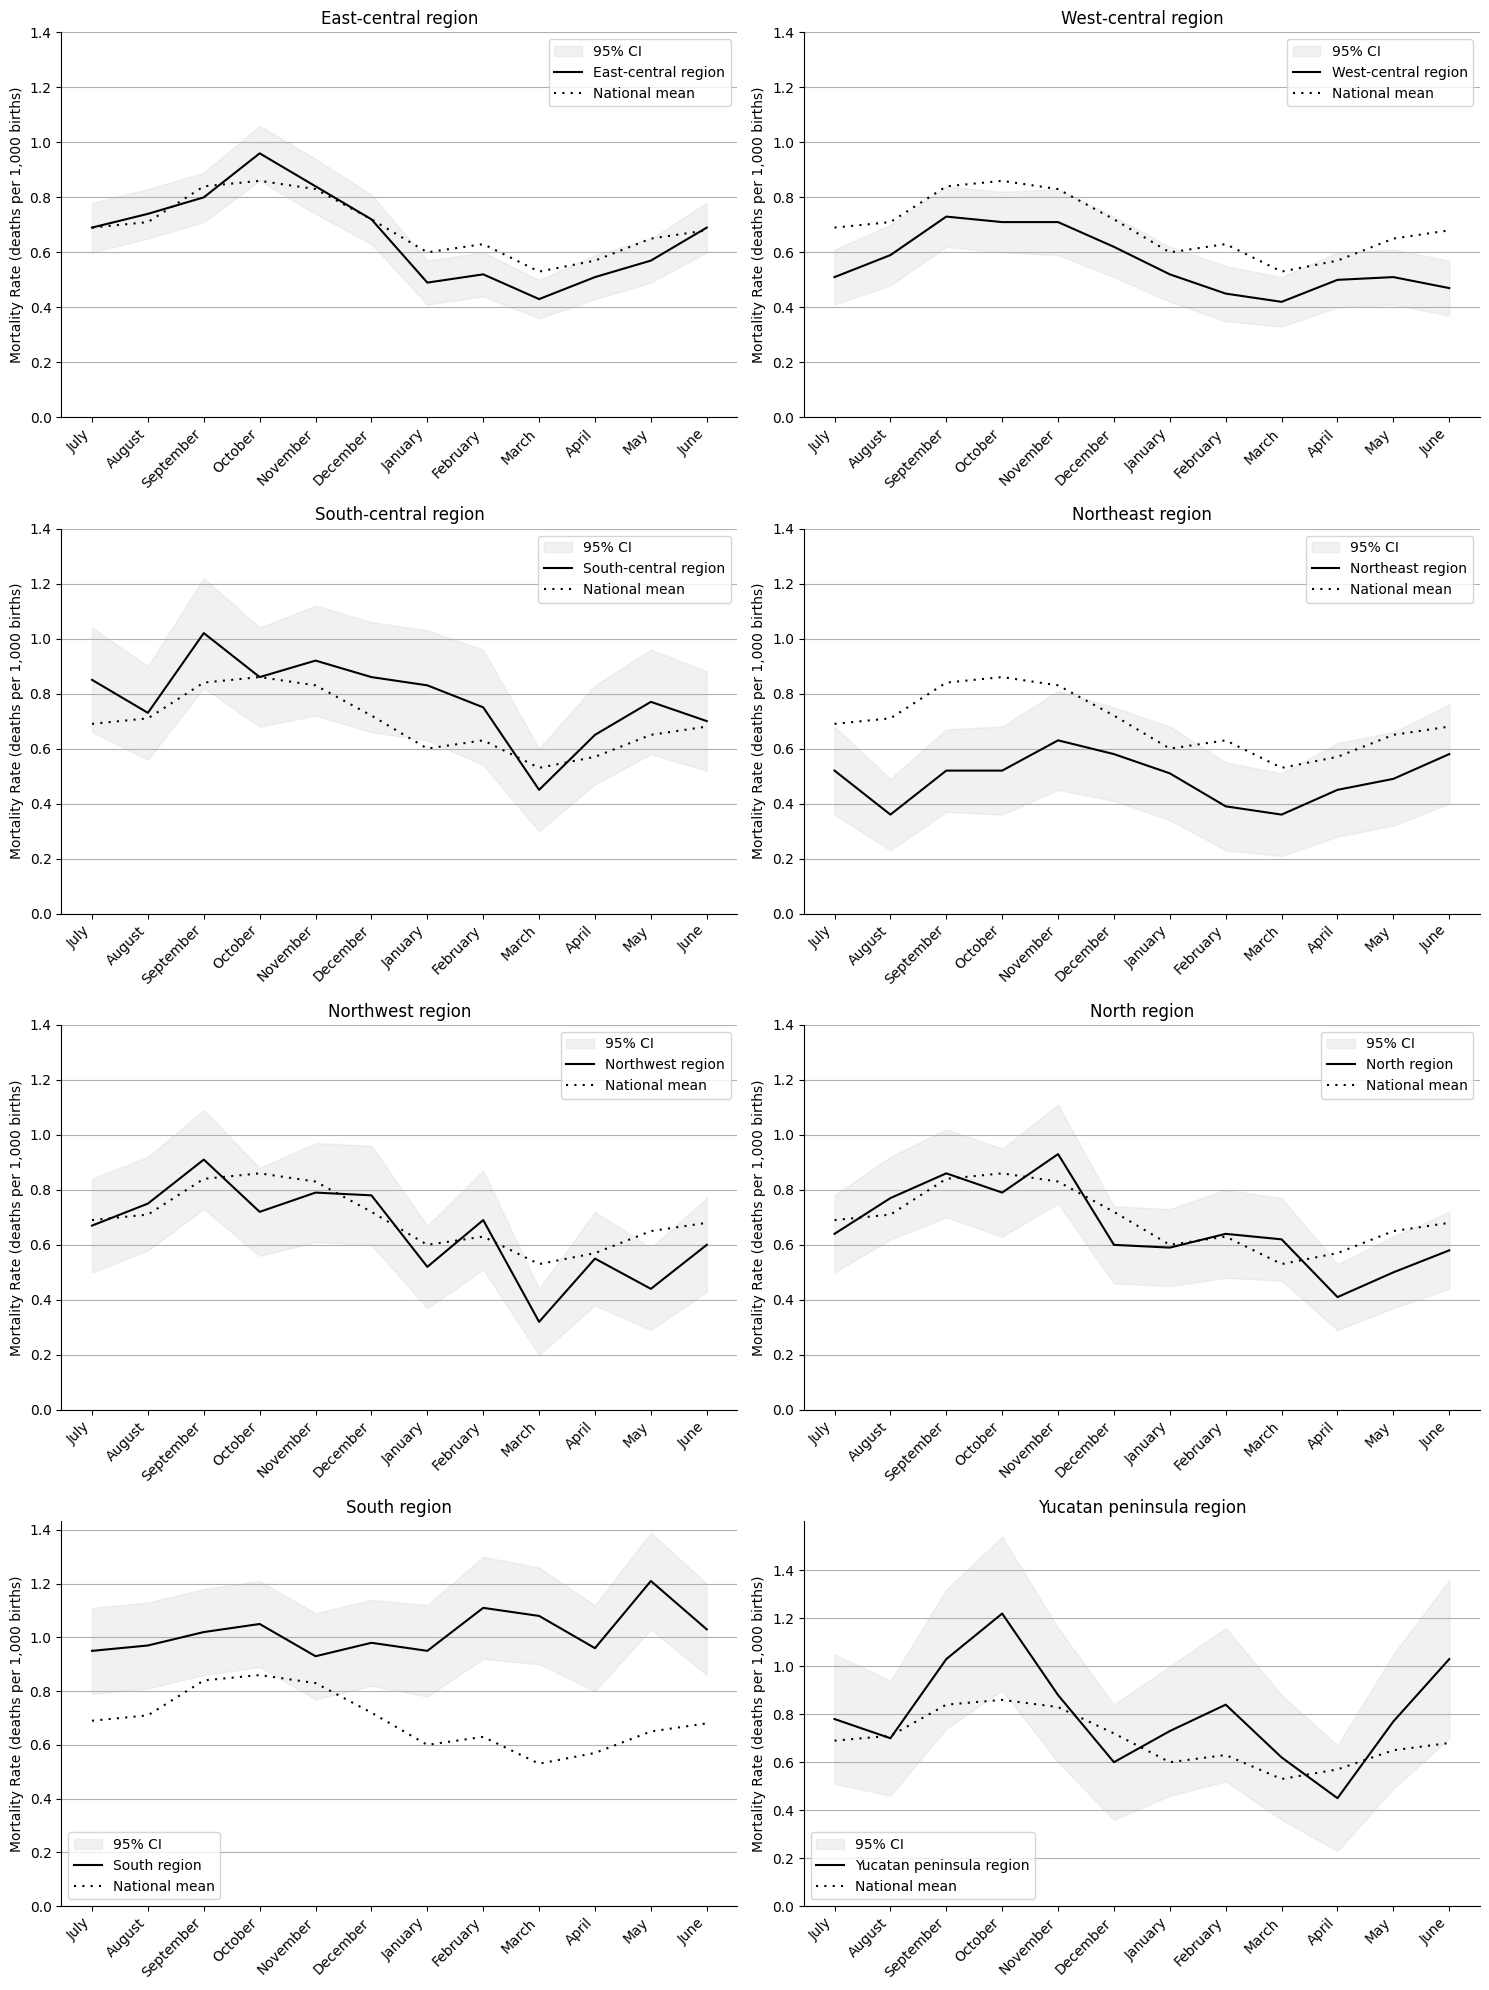

In [292]:
# Filter out the 'Yearly Avg' row
filtered_df = pivot_df[pivot_df['Month'] != 'Yearly Avg']

# Define the list of regions to be plotted
regions = [
    'East-central', 'West-central', 'South-central', 'Northeast',
    'Northwest', 'North', 'South', 'Yucatan peninsula'
]

# Set up the figure and axes for 4 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

# Plot each region in a separate subplot
for i, region in enumerate(regions):
    ax = axes[i]
    sub = ci_df[ci_df['Region'] == region]

    # plot shaded 95% CI band
    ax.fill_between(
        sub['Month'],
        sub['CI_Lower'],
        sub['CI_Upper'],
        color='lightgray',
        alpha=0.3,
        label='95% CI'
    )

    # Plot the region's mortality rate
    ax.plot(
        filtered_df['Month'], 
        filtered_df[region], 
        label=f'{region} region', 
        linestyle='-', 
        color='black' if grayscale else 'orange'
        )
    
    # Plot the national average for comparison
    ax.plot(
        filtered_df['Month'], 
        filtered_df['National'], 
        label='National mean', 
        linestyle=(0, (1, 3)), 
        color='black' if grayscale else 'blue'
        )
    
    # Set title and labels for each subplot
    ax.set_title(f'{region} region')
    #ax.set_xlabel('Month')
    ax.set_ylabel('Mortality Rate (deaths per 1,000 births)')
    ax.set_xticks(filtered_df['Month'])
    ax.set_xticklabels(filtered_df['Month'], rotation=45, ha='right')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add grid and legend
    ax.grid(axis='y')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.savefig(f'{plots_folder}/Fig3.{image_format}', format=image_format, dpi=1200)

# Show the plot
plt.show()

**Table 3.** Monthly mortality rates based on the occurence month.

In [293]:
# Registered deaths grouped by year/month of birth 
grouped_deaths_df1 = respiratory_illness_df1.groupby('MES_OCURR').size().reset_index(name='Deaths_Birth')
# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby('MES_NAC').size().reset_index(name='Births')


grouped_df = pd.merge(grouped_births_df, grouped_deaths_df1, left_on='MES_NAC', right_on='MES_OCURR', how='inner')

grouped_df.drop(columns=['MES_OCURR'], inplace=True)
grouped_df['Mortality_Rate_Birth'] =  (grouped_df['Deaths_Birth'] / grouped_df['Births'] *  1000).apply(lambda x: round(x, 2))

# Replace the 'MES_NAC' values with month names
grouped_df['MES_NAC'] = grouped_df['MES_NAC'].map(month_mapping)

# Convert the 'MES_NAC' column to a categorical type with the custom order
grouped_df['MES_NAC'] = pd.Categorical(grouped_df['MES_NAC'], categories=occurence_custom_order, ordered=True)

# Sort the dataframe based on the custom order
grouped_df = grouped_df.sort_values('MES_NAC')

grouped_df.rename(columns={'MES_NAC': 'Month', 'Mortality_Rate_Birth': 'Mortality_Rate'}, inplace=True)
monthly_mortality_rates = grouped_df[['Month', 'Mortality_Rate']]
monthly_mortality_rates.head(12)

,Month,Mortality_Rate
3,April,0.62
4,May,0.54
5,June,0.47
6,July,0.53
7,August,0.43
8,September,0.46
9,October,0.58
10,November,0.85
11,December,1.09
0,January,1.11


**Table 4.** Respiratory infant mortality rates by occurence month in Mexican children born between April 2014 and March 2020.

In [294]:
# Registered deaths grouped by year/month
grouped_deaths_df = respiratory_illness_df1.groupby(['ENT_RESID','MES_OCURR']).size().reset_index(name='Deaths')
grouped_deaths_df = pd.merge(grouped_deaths_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')

# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby(['ENT_RESID','MES_NAC']).size().reset_index(name='Births')
grouped_births_df = pd.merge(grouped_births_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')

grouped_df = pd.merge(grouped_births_df, grouped_deaths_df, left_on=['ENT_RESID', 'MES_NAC'], right_on=['ENT_RESID', 'MES_OCURR'], how='left')
grouped_df.drop(columns=['ENTIDAD_x','MES_OCURR','ENTIDAD_y','NOM_ENTIDAD_y', 'REGION_y'], inplace=True)
grouped_df.rename(columns={'REGION_x': 'Region', 'NOM_ENTIDAD_x': 'State', 'MES_NAC': 'Month'}, inplace=True)
grouped_df['Deaths'] = grouped_df['Deaths'].fillna(0)

grouped_df = grouped_df.groupby(['Region', 'Month'])[['Births', 'Deaths']].sum().reset_index()
r, lo, hi = rate_and_ci(grouped_df['Deaths'].values, grouped_df['Births'].values)
grouped_df['Mortality_Rate'] =  r

pivot_df = grouped_df.pivot(index='Month', columns='Region', values='Mortality_Rate').reset_index()

# Replace the 'Month' values with month names
pivot_df['Month'] = pivot_df['Month'].map(month_mapping)

# Convert the 'Month' column to a categorical type with the custom order
pivot_df['Month'] = pd.Categorical(pivot_df['Month'], categories=occurence_custom_order, ordered=True)

# Sort the dataframe based on the custom order
pivot_df = pivot_df.sort_values('Month')

# Add national mortality rates
pivot_df['National'] = monthly_mortality_rates['Mortality_Rate']

# Rename columns (For visualization purposes only)
pivot_df.rename(columns={
    'Centro Este': 'East-central',
    'Centro Occidente': 'West-central',
    'Centro Sur': 'South-central',
    'Noreste': 'Northeast',
    'Noroeste': 'Northwest',
    'Norte': 'North',
    'Sur': 'South',
    'Yucatan': 'Yucatan peninsula',
    }, inplace=True)

pivot_df.loc[:, pivot_df.columns != 'Month'] = pivot_df.loc[:, pivot_df.columns != 'Month'].round(2)

pivot_df.head(13)

Region,Month,East-central,West-central,South-central,Northeast,Northwest,North,South,Yucatan peninsula,National
3,April,0.45,0.56,0.67,0.54,0.72,0.53,1.04,0.80,0.62
4,May,0.39,0.50,0.75,0.36,0.67,0.38,0.96,0.69,0.54
5,June,0.42,0.35,0.57,0.25,0.37,0.34,0.93,0.68,0.47
6,July,0.46,0.43,0.57,0.40,0.38,0.39,1.03,0.78,0.53
7,August,0.36,0.33,0.58,0.37,0.28,0.36,0.80,0.48,0.43
8,September,0.40,0.41,0.55,0.19,0.36,0.36,0.77,0.80,0.46
9,October,0.59,0.39,0.63,0.37,0.46,0.53,0.96,0.90,0.58
10,November,0.92,0.63,0.88,0.59,0.68,0.70,1.28,1.12,0.85
11,December,1.29,0.77,1.10,0.70,1.03,1.36,1.12,0.92,1.09
0,January,1.09,0.95,1.20,0.96,1.17,1.39,1.18,0.84,1.11


In [295]:


# Calculate confidence intervals
ci_df = grouped_df.groupby(['Region', 'Month'])[['Births', 'Deaths']].sum().reset_index()
ci_df['Rate'], ci_df['CI_Lower'], ci_df['CI_Upper'] = rate_and_ci(ci_df['Deaths'], ci_df['Births'])

# merge with month names and order
ci_df['Month'] = ci_df['Month'].map(month_mapping)
ci_df['Month'] = pd.Categorical(ci_df['Month'], categories=occurence_custom_order, ordered=True)
ci_df = ci_df.sort_values(['Region', 'Month'])

# Rename ci_df Region values for consistency
ci_df['Region'] = ci_df['Region'].replace({
    'Centro Este': 'East-central',
    'Centro Occidente': 'West-central',
    'Centro Sur': 'South-central',
    'Noreste': 'Northeast',
    'Noroeste': 'Northwest',
    'Norte': 'North',
    'Sur': 'South',
    'Yucatan': 'Yucatan peninsula',
    })

ci_df.head(12)

,Region,Month,Births,Deaths,Rate,CI_Lower,CI_Upper
3,East-central,April,318596,144,0.45,0.38,0.52
4,East-central,May,327003,129,0.39,0.32,0.46
5,East-central,June,315566,131,0.42,0.35,0.49
6,East-central,July,331212,153,0.46,0.39,0.53
7,East-central,August,340441,124,0.36,0.30,0.42
8,East-central,September,347675,139,0.40,0.33,0.47
9,East-central,October,341278,202,0.59,0.51,0.67
10,East-central,November,316282,292,0.92,0.81,1.03
11,East-central,December,325198,418,1.29,1.17,1.41
0,East-central,January,315165,345,1.09,0.97,1.21


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


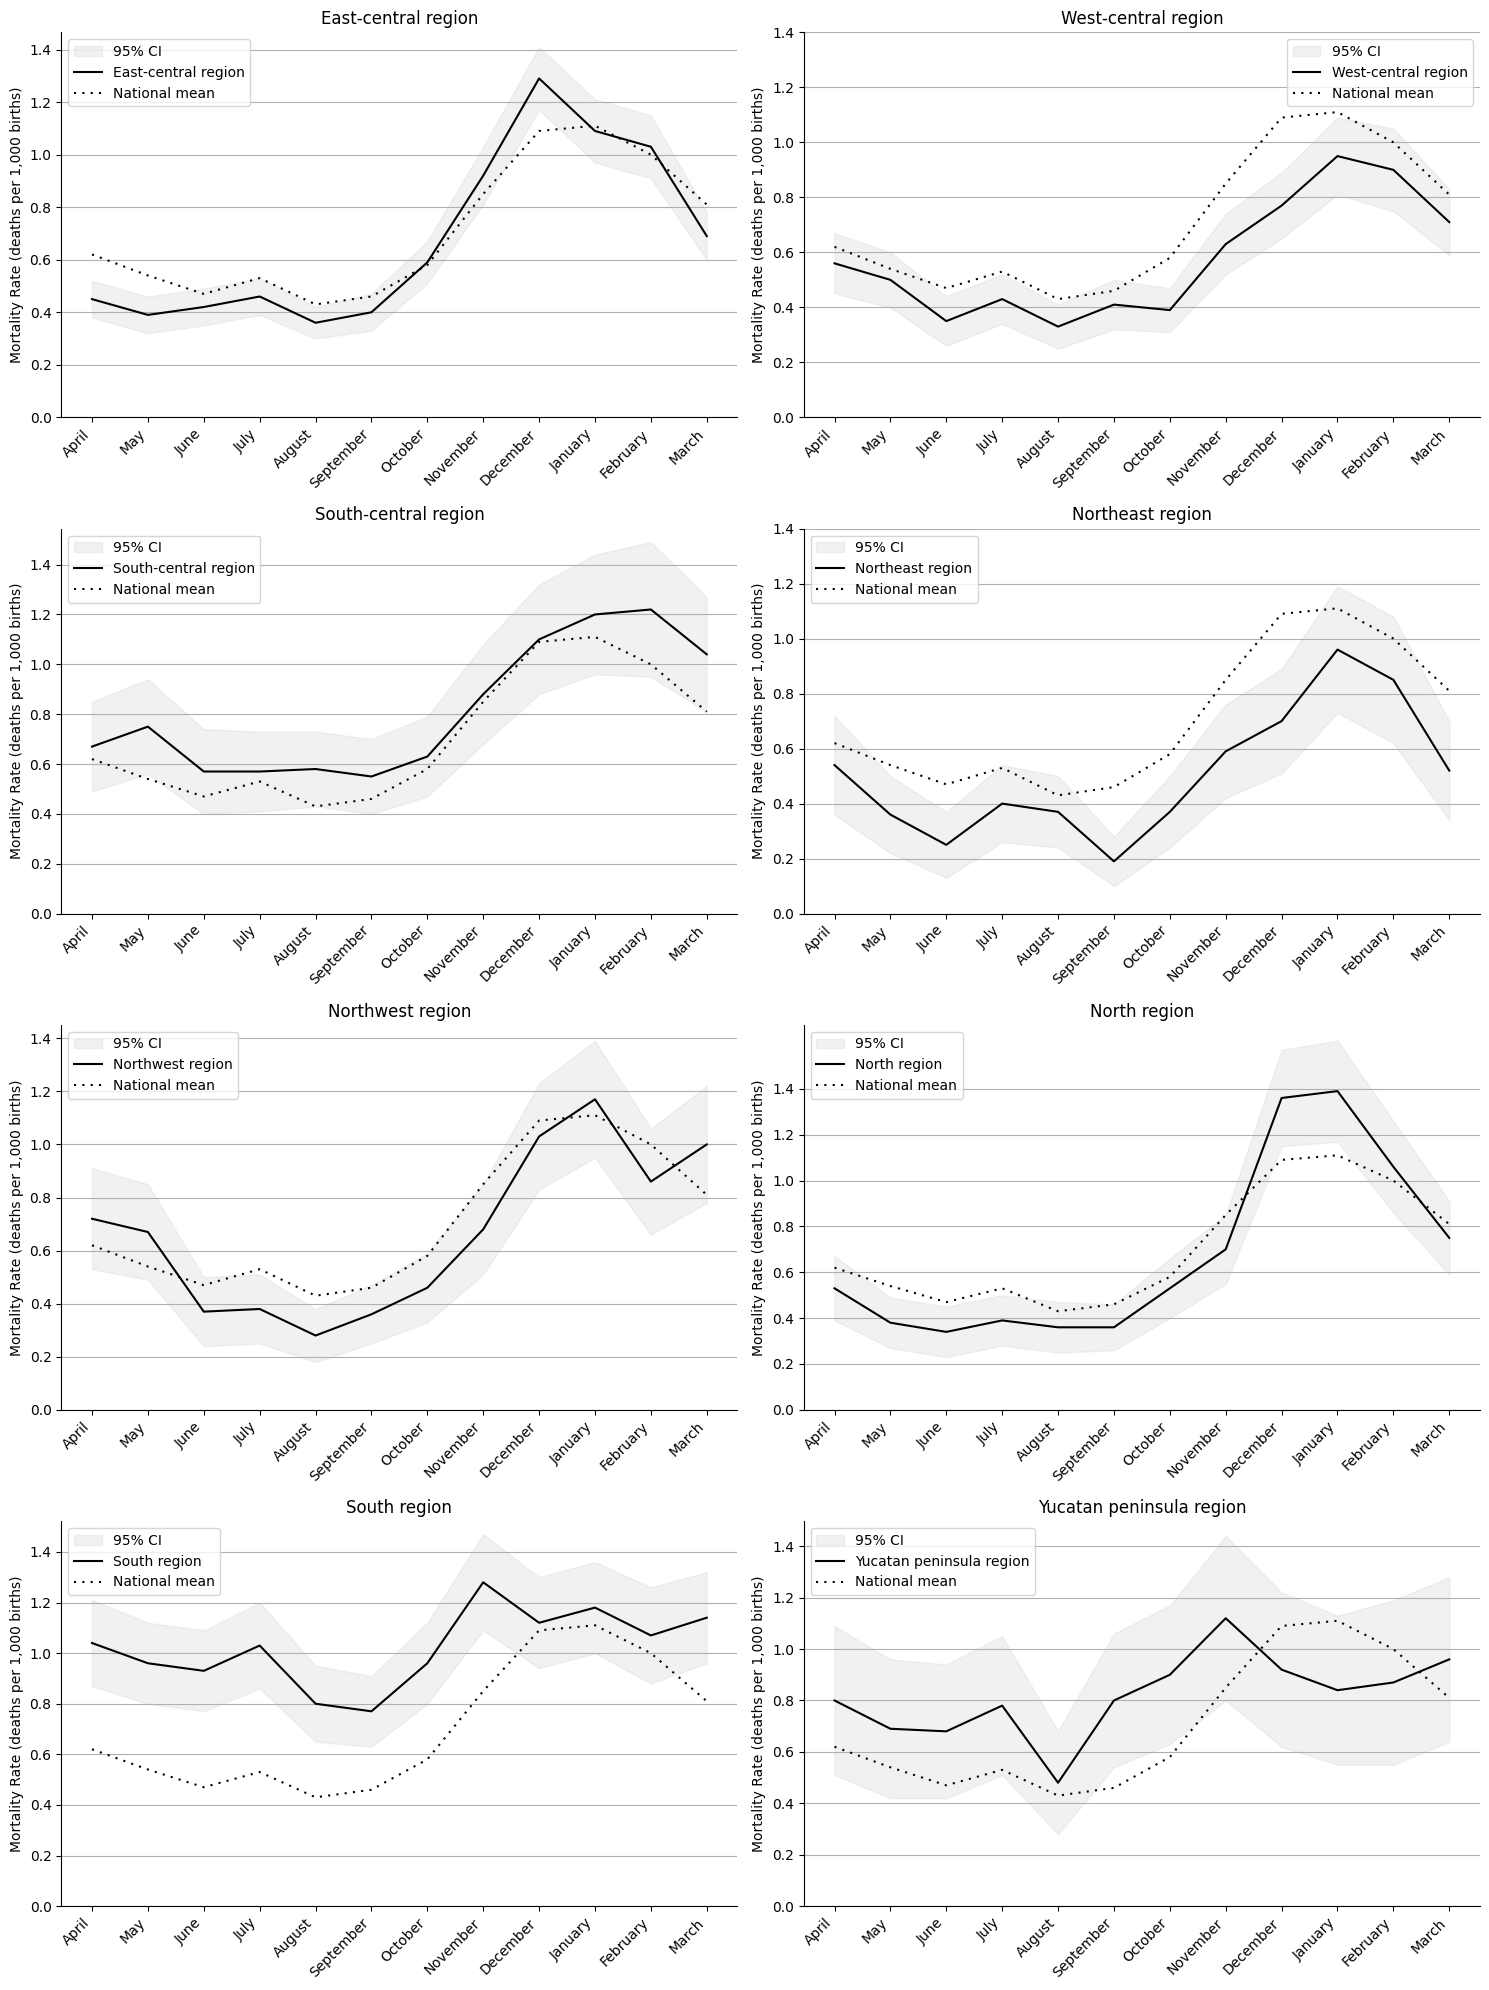

In [296]:
# Filter out the 'Yearly Avg' row
filtered_df = pivot_df[pivot_df['Month'] != 'Yearly Avg']

# Define the list of regions to be plotted
regions = [
    'East-central', 'West-central', 'South-central', 'Northeast',
    'Northwest', 'North', 'South', 'Yucatan peninsula'
]

# Set up the figure and axes for 4 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

# Plot each region in a separate subplot
for i, region in enumerate(regions):
    ax = axes[i]
    sub = ci_df[ci_df['Region'] == region]

    # plot shaded 95% CI band
    ax.fill_between(
        sub['Month'],
        sub['CI_Lower'],
        sub['CI_Upper'],
        color='lightgray',
        alpha=0.3,
        label='95% CI'
    )

    # Plot the region's mortality rate
    ax.plot(
        filtered_df['Month'], 
        filtered_df[region], 
        label=f'{region} region', 
        linestyle='-', 
        color='black' if grayscale else 'orange'
        )
    
    # Plot the national average for comparison
    ax.plot(
        filtered_df['Month'], 
        filtered_df['National'], 
        label='National mean', 
        linestyle=(0, (1, 3)), 
        color='black' if grayscale else 'blue'
        )
    
    # Set title and labels for each subplot
    ax.set_title(f'{region} region')
    #ax.set_xlabel('Month')
    ax.set_ylabel('Mortality Rate (deaths per 1,000 births)')
    ax.set_xticks(filtered_df['Month'])
    ax.set_xticklabels(filtered_df['Month'], rotation=45, ha='right')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add grid and legend
    ax.grid(axis='y')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.savefig(f'{plots_folder}/Fig9.{image_format}', format=image_format, dpi=1200)

# Show the plot
plt.show()

## Characteristics of infants born between April 2014 and March 2021

In [297]:
births_df = birth_records_df

births_df['EDAD_MADN'] = births_df['EDAD_MADN'].astype(float)
births_df['EDAD_MADN'] = births_df['EDAD_MADN'].replace(99.0, np.nan)

births_df['EDAD_PADN'] = births_df['EDAD_PADN'].astype(float)
births_df['EDAD_PADN'] = births_df['EDAD_PADN'].replace(99.0, np.nan)

births_df['ORDEN_PART'] = births_df['ORDEN_PART'].astype(float)
births_df['ORDEN_PART'] = births_df['ORDEN_PART'].replace(99.0, np.nan)

births_df['TIPO_NAC'] = births_df['TIPO_NAC'].astype(float)
births_df['TIPO_NAC'] = births_df['TIPO_NAC'].replace(9.0, np.nan)

births_df['LUGAR_PART'] = births_df['LUGAR_PART'].astype(float)
births_df['LUGAR_PART'] = births_df['LUGAR_PART'].replace(9.0, np.nan)

births_df['EDOCIV_MAD'] = births_df['EDOCIV_MAD'].astype(float)
births_df['EDOCIV_MAD'] = births_df['EDOCIV_MAD'].replace(9.0, np.nan)

births_df['ESCOL_MAD'] = births_df['ESCOL_MAD'].astype(float)
births_df['ESCOL_MAD'] = births_df['ESCOL_MAD'].replace(9.0, np.nan)

births_df['ESCOL_PAD'] = births_df['ESCOL_PAD'].astype(float)
births_df['ESCOL_PAD'] = births_df['ESCOL_PAD'].replace(9.0, np.nan)

Helper function: Summarize the total Xs being part of the Y. It can return the total matches or just the percentage.

In [298]:
def Is_Equal_To(x, y, usePercentage):
    if isinstance(y, (list, set, pd.Series)):  # Check if y is a list, set, or Series
        counter = x.isin(y).sum()
    elif pd.isna(y):  # Check if y is NaN
        counter = x.isna().sum()
    else:  # For scalar y
        counter = (x == y).sum()

    if usePercentage:
        total_count = len(x)
        return (counter / total_count) * 100 if total_count > 0 else 0
    else:
        return counter

In [299]:
aggregations = {
    'Total': ('MES_NAC', lambda x: x.notna().sum()),
    'Maternal_Age_Median': ('EDAD_MADN', lambda x: x.median(skipna=True)),
    'Paternal_Age_Median': ('EDAD_PADN', lambda x: x.median(skipna=True)),
    'Pregnancy_Number_Median': ('ORDEN_PART', lambda x: x.median(skipna=True)),
    'Singleton_Pregnancy': ('TIPO_NAC', lambda x: Is_Equal_To(x, 1, False)),
    'Singleton_Pregnancy_Percentage': ('TIPO_NAC', lambda x: round(Is_Equal_To(x, 1, True), 2)),
    'Hospital_Birth': ('LUGAR_PART', lambda x: Is_Equal_To(x, {1, 2}, False)),
    'Hospital_Birth_Percentage': ('LUGAR_PART', lambda x: round(Is_Equal_To(x, {1, 2}, True), 2)),
    'All_Specified_Birth_Place': ('LUGAR_PART', lambda x: Is_Equal_To(x, {1, 2, 3, 4}, False)),
    'Single_Mother': ('EDOCIV_MAD', lambda x: Is_Equal_To(x, 1., False)),
    'Single_Mother_Percentage': ('EDOCIV_MAD', lambda x: round(Is_Equal_To(x, 1, True), 2)),
    'Single_Divorced_Separated_Widow': ('EDOCIV_MAD', lambda x: Is_Equal_To(x, {1, 4, 5, 6}, False)),
    'Single_Divorced_Separated_Widow_Percentage': ('EDOCIV_MAD', lambda x: round(Is_Equal_To(x, {1, 4, 5, 6}, True), 2)),
    'All_Specified_Marital_Status': ('EDOCIV_MAD', lambda x: Is_Equal_To(x, {1, 2, 3, 4, 5, 6}, False))
}

grouped_df = births_df.groupby('MES_NAC').agg(**aggregations).reset_index()

grouped_df['Hospital_Birth_From_Specified'] = (grouped_df['Hospital_Birth'] / grouped_df['All_Specified_Birth_Place'] *  100).apply(lambda x: round(x, 2))
grouped_df['Single_Mother_From_Specified'] = (grouped_df['Single_Mother'] / grouped_df['All_Specified_Marital_Status'] *  100).apply(lambda x: round(x, 2))
grouped_df['Single_Divorced_Separated_Widow_From_Specified'] = (grouped_df['Single_Divorced_Separated_Widow'] / grouped_df['All_Specified_Marital_Status'] *  100).apply(lambda x: round(x, 2))
# Convert Maternal Age, Paternal Age, and Pregnancy number to Integers.
grouped_df['Maternal_Age_Median'] = grouped_df['Maternal_Age_Median'].astype(int)
grouped_df['Paternal_Age_Median'] = grouped_df['Paternal_Age_Median'].astype(int)
grouped_df['Pregnancy_Number_Median'] = grouped_df['Pregnancy_Number_Median'].astype(int)

grouped_df.rename(columns={'MES_NAC': 'Month'}, inplace=True)

# Replace the 'Month' values with month names
grouped_df['Month'] = grouped_df['Month'].map(month_mapping)

# Convert the 'Month' column to a categorical type with the custom order
grouped_df['Month'] = pd.Categorical(grouped_df['Month'], categories=custom_order, ordered=True)

# Sort the dataframe based on the custom order
grouped_df = grouped_df.sort_values('Month')

In [300]:
not_specified_birth_place =  (grouped_df['Total'].sum()) - (grouped_df['All_Specified_Birth_Place'].sum())
not_specified_birth_place_precentage = round(not_specified_birth_place / grouped_df['Total'].sum() *  100, 2)

print(f'Birth place not specified:  {not_specified_birth_place:,} ({not_specified_birth_place_precentage}%)')

Birth place not specified:  615,775 (4.89%)


In [301]:
not_specified_marital_status =  (grouped_df['Total'].sum()) - (grouped_df['All_Specified_Marital_Status'].sum())
not_specified_marital_status_precentage = round(not_specified_marital_status / grouped_df['Total'].sum() *  100, 2)

print(f'Marital status not specified:  {not_specified_marital_status:,} ({not_specified_marital_status_precentage}%)')

Marital status not specified:  737,473 (5.85%)


In [302]:
grouped_df = grouped_df[['Month', 'Total', 'Maternal_Age_Median', 'Paternal_Age_Median', 'Pregnancy_Number_Median', 'Singleton_Pregnancy',
                         'Singleton_Pregnancy_Percentage', 'Hospital_Birth', 'Hospital_Birth_Percentage', 'Hospital_Birth_From_Specified',
                         'Single_Mother', 'Single_Mother_Percentage', 'Single_Mother_From_Specified', 'Single_Divorced_Separated_Widow',
                         'Single_Divorced_Separated_Widow_Percentage', 'Single_Divorced_Separated_Widow_From_Specified']]

grouped_df.head(12)

,Month,Total,Maternal_Age_Median,Paternal_Age_Median,Pregnancy_Number_Median,Singleton_Pregnancy,Singleton_Pregnancy_Percentage,Hospital_Birth,Hospital_Birth_Percentage,Hospital_Birth_From_Specified,Single_Mother,Single_Mother_Percentage,Single_Mother_From_Specified,Single_Divorced_Separated_Widow,Single_Divorced_Separated_Widow_Percentage,Single_Divorced_Separated_Widow_From_Specified
6,July,1076970,25,28,2,1061802,98.59,981287,91.12,95.80,128979,11.98,12.73,133179,12.37,13.15
7,August,1136385,25,28,2,1120335,98.59,1037757,91.32,95.97,136162,11.98,12.73,140630,12.38,13.15
8,September,1181923,25,28,2,1166299,98.68,1079203,91.31,95.94,139359,11.79,12.51,144003,12.18,12.92
9,October,1153400,25,28,2,1137830,98.65,1051994,91.21,95.99,136668,11.85,12.58,141181,12.24,13.00
10,November,1056550,25,28,2,1043065,98.72,960163,90.88,95.84,127611,12.08,12.86,131599,12.46,13.26
11,December,1067736,25,28,2,1053562,98.67,968285,90.69,95.63,128483,12.03,12.83,132436,12.40,13.23
0,January,1019441,25,28,2,1005850,98.67,926037,90.84,95.50,124676,12.23,13.02,128456,12.60,13.41
1,February,902558,25,28,2,890437,98.66,822025,91.08,95.62,110659,12.26,13.01,114130,12.65,13.42
2,March,986549,25,28,2,972836,98.61,897612,90.99,95.56,119649,12.13,12.88,123348,12.50,13.28
3,April,994946,25,28,2,981828,98.68,904015,90.86,95.42,117510,11.81,12.51,121299,12.19,12.92


In [303]:
aggregations = {
    'Total': ('MES_NAC', lambda x: x.notna().sum()),
    'Mother_Without_Education_Level': ('ESCOL_MAD', lambda x: Is_Equal_To(x, 1, False)),
    'Percentage_Mother_Without_Education_Level': ('ESCOL_MAD', lambda x: round(Is_Equal_To(x, 1, True), 2)),
    'Mother_With_Elementary_School': ('ESCOL_MAD', lambda x: Is_Equal_To(x, {2, 3, 4}, False)),
    'Percentage_Mother_With_Elementary_School': ('ESCOL_MAD', lambda x: round(Is_Equal_To(x, {2, 3, 4}, True), 2)),
    'Mother_With_Elementary_Or_Without_Education': ('ESCOL_MAD', lambda x: Is_Equal_To(x, {1, 2, 3, 4}, False)),
    'Percentage_Mother_With_Elementary_Or_Without_Education': ('ESCOL_MAD', lambda x: round(Is_Equal_To(x, {1, 2, 3, 4}, True), 2)),
    'Mother_All_Specified_Education_Level': ('ESCOL_MAD', lambda x: Is_Equal_To(x, {1, 2, 3, 4, 5, 6, 7, 8}, False)),

    'Father_Without_Education_Level': ('ESCOL_PAD', lambda x: Is_Equal_To(x, 1, False)),
    'Percentage_Father_Without_Education_Level': ('ESCOL_PAD', lambda x: round(Is_Equal_To(x, 1, True), 2)),
    'Father_With_Elementary_School': ('ESCOL_PAD', lambda x: Is_Equal_To(x, {2, 3, 4}, False)),
    'Percentage_Father_With_Elementary_School': ('ESCOL_PAD', lambda x: round(Is_Equal_To(x, {2, 3, 4}, True), 2)),
    'Father_With_Elementary_Or_Without_Education': ('ESCOL_PAD', lambda x: Is_Equal_To(x, {1, 2, 3, 4}, False)),
    'Percentage_Father_With_Elementary_Or_Without_Education': ('ESCOL_PAD', lambda x: round(Is_Equal_To(x, {1, 2, 3, 4}, True), 2)),
    'Father_All_Specified_Education_Level': ('ESCOL_PAD', lambda x: Is_Equal_To(x, {1, 2, 3, 4, 5, 6, 7, 8}, False))
}

grouped_df = births_df.groupby('MES_NAC').agg(**aggregations).reset_index()

grouped_df['Mother_Without_Education_From_Specified'] = (grouped_df['Mother_Without_Education_Level'] / grouped_df['Mother_All_Specified_Education_Level'] *  100).apply(lambda x: round(x, 2))
grouped_df['Father_Without_Education_From_Specified'] = (grouped_df['Father_Without_Education_Level'] / grouped_df['Father_All_Specified_Education_Level'] *  100).apply(lambda x: round(x, 2))

grouped_df['Mother_With_Elementary_From_Specified'] = (grouped_df['Mother_With_Elementary_School'] / grouped_df['Mother_All_Specified_Education_Level'] *  100).apply(lambda x: round(x, 2))
grouped_df['Father_With_Elementary_From_Specified'] = (grouped_df['Father_With_Elementary_School'] / grouped_df['Father_All_Specified_Education_Level'] *  100).apply(lambda x: round(x, 2))


grouped_df['Mother_With_Elementary_Or_Without_Education_From_Specified'] = (grouped_df['Mother_With_Elementary_Or_Without_Education'] / grouped_df['Mother_All_Specified_Education_Level'] *  100).apply(lambda x: round(x, 2))
grouped_df['Father_With_Elementary_Or_Without_Education_From_Specified'] = (grouped_df['Father_With_Elementary_Or_Without_Education'] / grouped_df['Father_All_Specified_Education_Level'] *  100).apply(lambda x: round(x, 2))

grouped_df.rename(columns={'MES_NAC': 'Month'}, inplace=True)

# Replace the 'Month' values with month names
grouped_df['Month'] = grouped_df['Month'].map(month_mapping)

# Convert the 'Month' column to a categorical type with the custom order
grouped_df['Month'] = pd.Categorical(grouped_df['Month'], categories=custom_order, ordered=True)

# Sort the dataframe based on the custom order
grouped_df = grouped_df.sort_values('Month')

In [304]:
not_specified_education_level =  (grouped_df['Total'].sum()) - (grouped_df['Mother_All_Specified_Education_Level'].sum())
not_specified_education_level_precentage = round(not_specified_education_level / grouped_df['Total'].sum() *  100, 2)

print(f'No information regarding mother education level:  {not_specified_education_level:,} ({not_specified_education_level_precentage}%)')

No information regarding mother education level:  838,813 (6.65%)


In [305]:
not_specified_education_level =  (grouped_df['Total'].sum()) - (grouped_df['Father_All_Specified_Education_Level'].sum())
not_specified_education_level_precentage = round(not_specified_education_level / grouped_df['Total'].sum() *  100, 2)

print(f'No information regarding father education level:  {not_specified_education_level:,} ({not_specified_education_level_precentage}%)')

No information regarding father education level:  1,855,792 (14.72%)


In [306]:
grouped_df = grouped_df[['Month', 'Total', 'Mother_Without_Education_Level', 'Percentage_Mother_Without_Education_Level', 'Mother_Without_Education_From_Specified', 
                         'Mother_With_Elementary_School', 'Percentage_Mother_With_Elementary_School', 'Mother_With_Elementary_From_Specified',
                         'Mother_With_Elementary_Or_Without_Education', 'Percentage_Mother_With_Elementary_Or_Without_Education', 
                         'Mother_With_Elementary_Or_Without_Education_From_Specified',
                         'Father_Without_Education_Level', 'Percentage_Father_Without_Education_Level', 'Father_Without_Education_From_Specified',
                         'Father_With_Elementary_School', 'Percentage_Father_With_Elementary_School', 'Father_With_Elementary_From_Specified',
                         'Father_With_Elementary_Or_Without_Education', 'Percentage_Father_With_Elementary_Or_Without_Education', 
                         'Father_With_Elementary_Or_Without_Education_From_Specified']]

grouped_df.head(12)

,Month,Total,Mother_Without_Education_Level,Percentage_Mother_Without_Education_Level,Mother_Without_Education_From_Specified,Mother_With_Elementary_School,Percentage_Mother_With_Elementary_School,Mother_With_Elementary_From_Specified,Mother_With_Elementary_Or_Without_Education,Percentage_Mother_With_Elementary_Or_Without_Education,Mother_With_Elementary_Or_Without_Education_From_Specified,Father_Without_Education_Level,Percentage_Father_Without_Education_Level,Father_Without_Education_From_Specified,Father_With_Elementary_School,Percentage_Father_With_Elementary_School,Father_With_Elementary_From_Specified,Father_With_Elementary_Or_Without_Education,Percentage_Father_With_Elementary_Or_Without_Education,Father_With_Elementary_Or_Without_Education_From_Specified
6,July,1076970,20401,1.89,2.03,183036,17.00,18.21,203437,18.89,20.24,19625,1.82,2.14,187230,17.38,20.40,206855,19.21,22.54
7,August,1136385,21375,1.88,2.01,190590,16.77,17.96,211965,18.65,19.97,20751,1.83,2.14,195167,17.17,20.14,215918,19.00,22.28
8,September,1181923,22567,1.91,2.04,197797,16.74,17.90,220364,18.64,19.94,21984,1.86,2.17,203421,17.21,20.10,225405,19.07,22.28
9,October,1153400,22212,1.93,2.06,191135,16.57,17.75,213347,18.50,19.82,21631,1.88,2.19,196657,17.05,19.95,218288,18.93,22.15
10,November,1056550,20782,1.97,2.11,176192,16.68,17.89,196974,18.64,20.00,20197,1.91,2.24,181877,17.21,20.22,202074,19.13,22.46
11,December,1067736,21404,2.00,2.15,176522,16.53,17.77,197926,18.54,19.92,20685,1.94,2.28,182922,17.13,20.15,203607,19.07,22.42
0,January,1019441,20114,1.97,2.12,170321,16.71,17.92,190435,18.68,20.04,19445,1.91,2.24,174394,17.11,20.10,193839,19.01,22.34
1,February,902558,17534,1.94,2.08,150097,16.63,17.81,167631,18.57,19.89,17072,1.89,2.22,154890,17.16,20.12,171962,19.05,22.34
2,March,986549,18890,1.91,2.05,165146,16.74,17.93,184036,18.65,19.98,18172,1.84,2.16,169659,17.20,20.19,187831,19.04,22.35
3,April,994946,19461,1.96,2.09,175816,17.67,18.91,195277,19.63,21.00,18373,1.85,2.17,179252,18.02,21.13,197625,19.86,23.30


In [307]:
def Is_Equal_To(x, y, usePercentage):
    if isinstance(y, (list, set, pd.Series)):  # Check if y is a list, set, or Series
        counter = x.isin(y).sum()
    elif pd.isna(y):  # Check if y is NaN
        counter = x.isna().sum()
    else:  # For scalar y
        counter = (x == y).sum()
    
    if usePercentage:
        total_count = len(x)
        return (counter / total_count) * 100 if total_count > 0 else 0
    else:
        return counter

In [308]:
def determine_age_in_months(age):
    if age < 3001:
        return 0
    elif age == 3001:
        return 1
    elif age == 3002:
        return 2
    elif age == 3003:
        return 3
    elif age == 3004:
        return 4
    elif age == 3005:
        return 5
    elif age == 3006:
        return 6
    elif age == 3007:
        return 7
    elif age == 3008:
        return 8
    elif age == 3009:
        return 9
    elif age == 3010:
        return 10
    elif age == 3011:
        return 11
    else:
        return None

In [309]:
respiratory_illness_df1['EDAD_MESES'] = respiratory_illness_df1['EDAD'].apply(determine_age_in_months)

/tmp/ipykernel_3379182/1722330210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respiratory_illness_df1['EDAD_MESES'] = respiratory_illness_df1['EDAD'].apply(determine_age_in_months)


In [310]:
grouped_births_df = births_df.groupby('MES_NAC').size().reset_index(name='Nacimientos')
grouped_births_df.rename(columns={'MES_NAC': 'MES_NACIM'}, inplace=True)
grouped_births_df.head(12)

,MES_NACIM,Nacimientos
0,1,1019441
1,2,902558
2,3,986549
3,4,994946
4,5,1024246
5,6,1004198
6,7,1076970
7,8,1136385
8,9,1181923
9,10,1153400


In [311]:
aggregations = {
    str(i): ('EDAD_MESES', lambda x, i=i: Is_Equal_To(x, i, False)) for i in range(12)
}

grouped_df = respiratory_illness_df1.groupby('MES_NACIM').agg(**aggregations).reset_index()
grouped_df = pd.merge(grouped_births_df, grouped_df, left_on='MES_NACIM', right_on='MES_NACIM')
grouped_df = grouped_df.set_index('MES_NACIM')
grouped_df = grouped_df.loc[[4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]].reset_index()

# Create a dictionary to map numeric values to month names
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Map the month names to 'MES_NACIM'
grouped_df['MES_NACIM'] = grouped_df['MES_NACIM'].map(month_map)

# Update the columns '1' ~ '11' to calculate death rates
for col in map(str, range(0, 12)):
    grouped_df[col] = ((grouped_df[col] / grouped_df['Nacimientos']) * 1000).apply(lambda x: round(x, 2))

grouped_df.drop(columns=['Nacimientos'], inplace=True)


# Set the index to 'Mes de nacimiento'
grouped_df.set_index('MES_NACIM', inplace=True)

new_columns = list(range(1, 13))  # Creating a list from 1 to 12
grouped_df.columns = new_columns  # Assigning the new list of columns

In [312]:
grouped_df.head(12)

,1,2,3,4,5,6,7,8,9,10,11,12
MES_NACIM,,,,,,,,,,,,
April,0.02,0.09,0.08,0.07,0.05,0.04,0.05,0.05,0.03,0.04,0.03,0.03
May,0.02,0.09,0.09,0.06,0.06,0.06,0.05,0.07,0.05,0.03,0.04,0.02
June,0.01,0.11,0.09,0.07,0.08,0.07,0.08,0.06,0.03,0.03,0.03,0.02
July,0.02,0.09,0.10,0.10,0.10,0.09,0.06,0.04,0.04,0.02,0.02,0.01
August,0.02,0.09,0.13,0.11,0.10,0.08,0.04,0.03,0.04,0.04,0.01,0.02
September,0.03,0.13,0.18,0.17,0.10,0.06,0.05,0.03,0.02,0.02,0.03,0.02
October,0.02,0.18,0.24,0.11,0.08,0.06,0.06,0.03,0.03,0.02,0.02,0.02
November,0.02,0.25,0.18,0.10,0.08,0.04,0.03,0.03,0.02,0.02,0.02,0.02
December,0.04,0.18,0.15,0.08,0.04,0.05,0.04,0.04,0.03,0.03,0.03,0.03


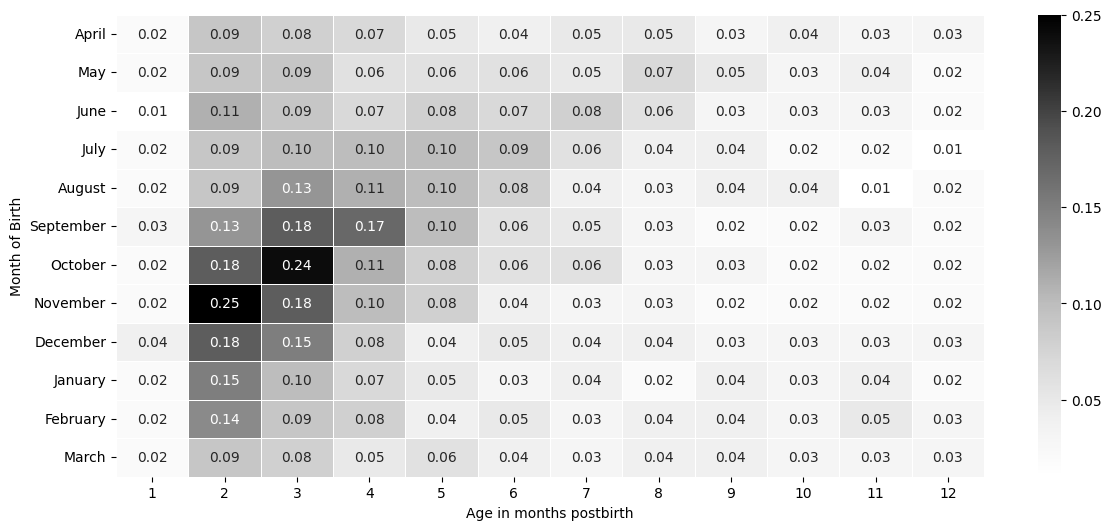

In [313]:
# Plot the heatmap with custom colormap
plt.figure(figsize=(14, 6))
sns.heatmap(grouped_df, annot=True, cmap='Greys' if grayscale else 'RdYlGn_r', linewidths=.5, fmt='.2f')
plt.ylabel('Month of Birth')
plt.xlabel('Age in months postbirth')


plt.savefig(f'{plots_folder}/Fig8.{image_format}', format=image_format, dpi=1200)

plt.show()

In [314]:
# Registered deaths grouped by year/month of birth 
grouped_deaths_df = respiratory_illness_df1.groupby(['ENT_RESID','MES_NACIM']).size().reset_index(name='Deaths')
grouped_deaths_df = grouped_deaths_df[grouped_deaths_df['ENT_RESID'] == 24]
grouped_deaths_df = pd.merge(grouped_deaths_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')
#grouped_deaths_df = grouped_deaths_df.groupby(['REGION','MES_NACIM']).size().reset_index(name='Deaths')

# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby(['ENT_RESID','MES_NAC']).size().reset_index(name='Births')
grouped_births_df = grouped_births_df[grouped_births_df['ENT_RESID'] == 24]
grouped_births_df = pd.merge(grouped_births_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')

grouped_df = pd.merge(grouped_births_df, grouped_deaths_df, left_on=['ENT_RESID', 'MES_NAC'], right_on=['ENT_RESID', 'MES_NACIM'], how='left')
grouped_df.drop(columns=['ENTIDAD_x','MES_NACIM','ENTIDAD_y','NOM_ENTIDAD_y', 'REGION_y'], inplace=True)
grouped_df.rename(columns={'REGION_x': 'Region', 'NOM_ENTIDAD_x': 'State', 'MES_NAC': 'Month'}, inplace=True)
grouped_df['Deaths'] = grouped_df['Deaths'].fillna(0)

grouped_df = grouped_df.groupby(['State', 'Month'])[['Births', 'Deaths']].sum().reset_index()
grouped_df['Mortality_Rate'] =  grouped_df['Deaths'] / grouped_df['Births'] *  1000

pivot_df = grouped_df.pivot(index='Month', columns='State', values='Mortality_Rate').reset_index()

# Replace the 'Month' values with month names
pivot_df['Month'] = pivot_df['Month'].map(month_mapping)

# Convert the 'Month' column to a categorical type with the custom order
pivot_df['Month'] = pd.Categorical(pivot_df['Month'], categories=custom_order, ordered=True)

# Sort the dataframe based on the custom order
pivot_df = pivot_df.sort_values('Month')


pivot_df.head(13)

State,Month,San Luis Potosi
6,July,0.649746
7,August,0.802108
8,September,0.794425
9,October,0.559451
10,November,0.794680
11,December,0.363534
0,January,0.474772
1,February,0.938828
2,March,0.450065
3,April,0.090506


In [315]:
# Registered deaths grouped by year/month of demise
grouped_deaths_df = respiratory_illness_df1.groupby(['ENT_RESID','MES_OCURR']).size().reset_index(name='Deaths')
grouped_deaths_df = grouped_deaths_df[grouped_deaths_df['ENT_RESID'] == 24]
grouped_deaths_df = pd.merge(grouped_deaths_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')

# Register births grouped by year/month
grouped_births_df = birth_records_df.groupby(['ENT_RESID','MES_NAC']).size().reset_index(name='Births')
grouped_births_df = grouped_births_df[grouped_births_df['ENT_RESID'] == 24]
grouped_births_df = pd.merge(grouped_births_df, states_df, left_on='ENT_RESID', right_on='ENTIDAD', how='inner')

grouped_df = pd.merge(grouped_births_df, grouped_deaths_df, left_on=['ENT_RESID', 'MES_NAC'], right_on=['ENT_RESID', 'MES_OCURR'], how='left')
grouped_df.drop(columns=['ENTIDAD_x','MES_OCURR','ENTIDAD_y','NOM_ENTIDAD_y', 'REGION_y'], inplace=True)
grouped_df.rename(columns={'REGION_x': 'Region', 'NOM_ENTIDAD_x': 'State', 'MES_NAC': 'Month'}, inplace=True)
grouped_df['Deaths'] = grouped_df['Deaths'].fillna(0)

grouped_df = grouped_df.groupby(['State', 'Month'])[['Births', 'Deaths']].sum().reset_index()
grouped_df['Mortality_Rate'] =  grouped_df['Deaths'] / grouped_df['Births'] *  1000



pivot_df = grouped_df.pivot(index='Month', columns='State', values='Mortality_Rate').reset_index()

# Replace the 'Month' values with month names
pivot_df['Month'] = pivot_df['Month'].map(month_mapping)

# Convert the 'Month' column to a categorical type with the custom order
pivot_df['Month'] = pd.Categorical(pivot_df['Month'], categories=occurence_custom_order, ordered=True)

# Sort the dataframe based on the custom order
pivot_df = pivot_df.sort_values('Month')

pivot_df.head(13)

State,Month,San Luis Potosi
3,April,0.724047
4,May,0.173521
5,June,0.220090
6,July,0.203046
7,August,0.420152
8,September,0.361102
9,October,0.484858
10,November,0.669204
11,December,1.332956
0,January,0.690578
